# Different Models

The first aim here is to find tasks that some models can do but others can't (so that we know something interesting is happening, rather than just e.g. skip trigrams). There are a variety of models to do this with, within [EasyTransformer](https://github.com/neelnanda-io/Easy-Transformer).

## Imports

In [18]:
!pip install git+https://github.com/neelnanda-io/Easy-Transformer ipython torchtyping circuitsvis

# Clear output
from IPython.display import clear_output
clear_output()

In [25]:
from easy_transformer import EasyTransformer
import torch
from IPython.core.display import HTML, clear_output
from typing import List
import pandas as pd
import copy
import numpy as np
from torchtyping import TensorType
from torch.nn import functional as F
from circuitsvis.tokens import colored_tokens

/tmp/ipykernel_32/4276320079.py:3: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, clear_output


## Models available

In [6]:
from easy_transformer import loading_from_pretrained
", ".join(loading_from_pretrained.OFFICIAL_MODEL_NAMES)

'gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2, facebook/opt-125m, facebook/opt-1.3b, facebook/opt-2.7b, facebook/opt-6.7b, facebook/opt-13b, facebook/opt-30b, facebook/opt-66b, EleutherAI/gpt-neo-125M, EleutherAI/gpt-neo-1.3B, EleutherAI/gpt-neo-2.7B, EleutherAI/gpt-j-6B, EleutherAI/gpt-neox-20b, stanford-crfm/alias-gpt2-small-x21, stanford-crfm/battlestar-gpt2-small-x49, stanford-crfm/caprica-gpt2-small-x81, stanford-crfm/darkmatter-gpt2-small-x343, stanford-crfm/expanse-gpt2-small-x777, stanford-crfm/arwen-gpt2-medium-x21, stanford-crfm/beren-gpt2-medium-x49, stanford-crfm/celebrimbor-gpt2-medium-x81, stanford-crfm/durin-gpt2-medium-x343, stanford-crfm/eowyn-gpt2-medium-x777, EleutherAI/pythia-19m, EleutherAI/pythia-125m, EleutherAI/pythia-350m, EleutherAI/pythia-800m, EleutherAI/pythia-1.3b, EleutherAI/pythia-6.7b, EleutherAI/pythia-13b, EleutherAI/pythia-125m-deduped, EleutherAI/pythia-800m-deduped, EleutherAI/pythia-1.3b-deduped, EleutherAI/pythia-6.7b-deduped, NeelNanda/SoL

## Introduction

Code completion in language models is pretty sophisticated. For example GitHub Copilot successfully solves problem prompts with solutions, like this.

### Python prompt

Starting with this prompt from a coding test:

```python
# Two Sum

# Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.

# You may assume that each input would have exactly one solution, and you may not use the same element twice.

# You can return the answer in any order.

class Solution(object):
    def twoSum(self, nums, target):
```

### Solution

```python
"""
:type nums1: List[int]
:type nums2: List[int]
:rtype: float
"""
nums1.extend(nums2)
nums1.sort()
if len(nums1)%2 == 0:
    return (nums1[len(nums1)//2] + nums1[len(nums1)//2 - 1])/2
else:
    return nums1[len(nums1)//2]
```


Some interesting observations of learnt skills here include:

- Deep stuff: understanding the problem from the comments, and formulating a high level solution.
- Keeping track of if/else blocks & brackets
- Using previously defined variables (perhaps similar to induction heads)
- Knowing variable types (both primitives and library types)
- Knowing the methods within classes
- Understanding underlying maths (e.g. what modulus and floor divide actually do)
- Understanding broadly how a function works (e.g. it typically returns something)
- Known line spacing

## Finding interesting problems for different models

### Models to try

In [7]:
# Models to use
models = [
    "NeelNanda/SoLU_1L512W_C4_Code", 
    "NeelNanda/SoLU_2L512W_C4_Code",
    "NeelNanda/SoLU_3L512W_C4_Code", 
    "NeelNanda/SoLU_4L512W_C4_Code", 
    # "NeelNanda/SoLU_6L768W_C4_Code", 
    # "NeelNanda/SoLU_8L1024W_C4_Code", 
    # "NeelNanda/SoLU_10L1280W_C4_Code", 
    # "NeelNanda/SoLU_12L1536W_C4_Code", 
    # "NeelNanda/GELU_1L512W_C4_Code", 
    # "NeelNanda/GELU_2L512W_C4_Code", 
    # "NeelNanda/GELU_3L512W_C4_Code", 
    # "NeelNanda/GELU_4L512W_C4_Code", 
    "NeelNanda/Attn_Only_1L512W_C4_Code", 
    "NeelNanda/Attn_Only_2L512W_C4_Code", 
    "NeelNanda/Attn_Only_3L512W_C4_Code", 
    "NeelNanda/Attn_Only_4L512W_C4_Code",
    # "gpt2",
    # "gpt2-medium"
]

### Prompt

In [8]:
# Prompt (The main CircuitsVis render functionality)
prompt = '''import json
import subprocess
from pathlib import Path
from typing import Optional
from uuid import uuid4

REACT_DIR = Path(__file__).parent.parent.parent / "react"


class RenderedHTML:
    """Rendered HTML
    Enables rendering HTML in a variety of situations (e.g. Jupyter Lab)
    """

    def __init__(self, src: str):
        self.src = src

    def _repr_html_(self) -> str:
        """Jupyter/Colab HTML Representation
        When Jupyter sees this method, it renders the HTML.
        Returns:
            str: HTML for Jupyter/Colab
        """
        return self.src

    def __html__(self) -> str:
        """Used by some tooling as an alternative to _repr_html_"""
        return self.src

    def show_code(self) -> str:
        """Show the code as source-code
        Returns:
            str: HTML source code
        """
        return self.src

    def __str__(self):
        """String type conversion handler"""
        return self.src


def install_if_necessary() -> None:
    """Install node modules if they're missing."""
    node_modules = REACT_DIR / "node_modules"
    if not node_modules.exists():
        subprocess.run(
            ["yarn"],
            cwd=REACT_DIR,
            capture_output=True,
            text=True,
            check=True
        )


def bundle_source() -> None:
    """Bundle up the JavaScript/TypeScript source files"""
    subprocess.run([
        "yarn",
        "buildBrowser"
    ],
        cwd=REACT_DIR,
        capture_output=True,
        text=True,
        check=True
    )


def render_dev(react_element_name: str, **kwargs) -> RenderedHTML:
    """Render (during development)"""
    # Create a random ID for the div (that we render into)
    # This is done to avoid name clashes on a page with many rendered
    # CircuitsVis elements. Note we shorten the UUID to be a reasonable length
    uuid = "circuits-vis-" + str(uuid4())[:13]

    # Stringify keyword args
    props = json.dumps(kwargs)

    # Build
    install_if_necessary()
    bundle_source()

    # Load the JS
    filename = REACT_DIR / "dist" / "cdn" / "iife.js"
    with open(filename, encoding="utf-8") as file:
        inline_js = file.read()

    html = f"""<div id="{uuid}"/>
    <script crossorigin type="module">
    {inline_js}
    
    CircuitsVis.render(
      "{uuid}",
      CircuitsVis.{react_element_name},
      {props}
    )
    </script>"""

    return RenderedHTML(html)


def render_prod(react_element_name: str, **kwargs) -> RenderedHTML:
    """Render (for production)"""
    # Create a random ID for the div (that we render into)
    # This is done to avoid name clashes on a page with many rendered
    # CircuitsVis elements. Note we shorten the UUID to be a reasonable length
    uuid = "circuits-vis-" + str(uuid4())[:13]

    # Stringify keyword args
    props = json.dumps(kwargs)

    html = f"""<div id="{uuid}"/>
    <script crossorigin type="module">
    import {"{ render, "+ react_element_name + " }"} from "https://unpkg.com/circuitsvis/dist/cdn/esm.js";
    render(
      "{uuid}",
      {react_element_name},
      {props}
    )
    </script>"""

    return RenderedHTML(html)'''

### Try prompt with all models

In [9]:
model_results = {}

for model_idx, model_name in enumerate(models):
    # Free up CUDA memory (from previous model)
    torch.cuda.empty_cache()
    
    # Load up the model
    model = EasyTransformer.from_pretrained(model_name)
    
    # Get the predictions
    logits: TensorType["batch", "position", "vocab"] = model(prompt)
    logits_single_batch: TensorType["position", "vocab"] = logits[0]
    logits_except_last: TensorType["position", "vocab"] = logits_single_batch[1:-1, :] # We also remove the first (start of sequence token)
    # predictions: TensorType["batch", "position", "vocab"] = torch.argmax(logits, 2)
    
    # Get the probabilities
    probabilities: TensorType["position", "vocab"] = F.softmax(logits_except_last, dim=1)
    probabilities_np = probabilities.detach().cpu().numpy()
    
    # Get the probabilities of the correct tokens
    correct_tokens = model.tokenizer.encode(prompt)[1:]
    correct_tokens_np = np.array(correct_tokens)
    
    print(correct_tokens_np.shape, probabilities_np.shape) # (856,) torch.Size([856, 48262])
    probabilities_correct = probabilities_np[np.arange(len(probabilities_np)),correct_tokens_np]
    
    
    
    # predictions_except_last = predictions.cpu().squeeze().numpy()[1:-1]
    # accurate = np.equal(np.array(correct_tokens),(predictions_except_last))
    
    # Store
    model_results[model_name] = probabilities_correct

    
clear_output()     

# Create the results DataFrame
results = pd.DataFrame(model_results)

# Set the token labels
tokens = model.tokenizer.encode(prompt)
token_labels = [model.tokenizer.decode(token) for token in tokens[0:-1]]
results.insert(0, "Token", token_labels)

In [10]:
# Show the average probability of the correct tokens by model
results_by_model = pd.DataFrame(model_results)
average_results_by_model = results_by_model.mean()
average_results_by_model.apply(lambda x: "{:.2%}".format(x))

NeelNanda/SoLU_1L512W_C4_Code         28.01%
NeelNanda/SoLU_2L512W_C4_Code         47.57%
NeelNanda/SoLU_3L512W_C4_Code         49.94%
NeelNanda/SoLU_4L512W_C4_Code         51.09%
NeelNanda/Attn_Only_1L512W_C4_Code    23.76%
NeelNanda/Attn_Only_2L512W_C4_Code    41.71%
NeelNanda/Attn_Only_3L512W_C4_Code    45.06%
NeelNanda/Attn_Only_4L512W_C4_Code    46.81%
dtype: object

### Results

In [47]:
def compare_model_correct_token_probability(modelA: str, modelB: str) -> pd.DataFrame:
    """Compare the correct token probabilities of two models

    Args:
        modelA (str): Model name (of model that is expected to be better)
        modelB (str): Model name (of model that is expected to be worse)

    Returns:
        pd.DataFrame: DataFrame with the relative accuracy of each model
    """
    relevant_results = results[["Token",modelA, modelB]]
    diff = relevant_results[modelA] - relevant_results[modelB]
    relevant_results.insert(3, "Difference", diff)
    # relevant_results = relevant_results.sort_values(by="Difference", ascending=False)
    return relevant_results

#### MLP vs Attention Only

array([[<AxesSubplot:title={'center':'Difference'}>]], dtype=object)

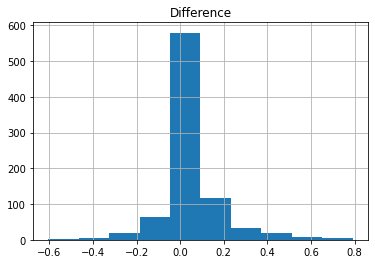

In [56]:
mlp_difference = compare_model_correct_token_probability("NeelNanda/SoLU_1L512W_C4_Code", "NeelNanda/Attn_Only_1L512W_C4_Code")
mlp_difference.hist(column="Difference", bins=10)

##### By Tokens View

In [63]:
values = mlp_difference["Difference"].sort_index().values.tolist()
colored_tokens(
    values=values,
    tokens=token_labels,
    min_value=0,
    max_value=1,
    max_color="green",
)

#### 1 vs 2 Layers

array([[<AxesSubplot:title={'center':'Difference'}>]], dtype=object)

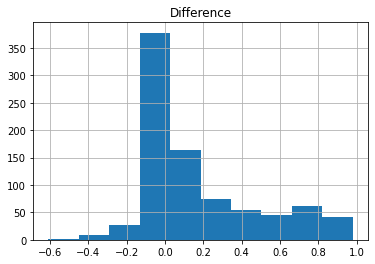

In [13]:
two_vs_one_layer = compare_model_correct_token_probability("NeelNanda/Attn_Only_2L512W_C4_Code", "NeelNanda/Attn_Only_1L512W_C4_Code")
two_vs_one_layer.hist(column="Difference", bins=10)

##### By Tokens View

In [64]:
values = two_vs_one_layer["Difference"].sort_index().values.tolist()
colored_tokens(
    values=values,
    tokens=token_labels,
    min_value=0,
    max_value=1,
    max_color="green",
)

#### 2 vs 3 Layers

array([[<AxesSubplot:title={'center':'Difference'}>]], dtype=object)

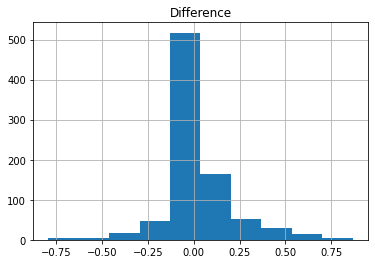

In [14]:
three_vs_two_layer = compare_model_correct_token_probability("NeelNanda/Attn_Only_3L512W_C4_Code", "NeelNanda/Attn_Only_2L512W_C4_Code")
three_vs_two_layer.hist(column="Difference", bins=10)